# Modeling

## Import basic packages and os

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
import os

## Importing train-test split data

In [2]:
%store -r X_train X_test X_val y_train y_test y_val

In [3]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((238352, 9), (29794, 9), (29794, 9), (238352,), (29794,), (29794,))

In [4]:
X_train = X_train.copy()
X_test = X_test.copy()
X_val = X_val.copy()
y_train = y_train.copy()
y_test = y_test.copy()
y_val = y_val.copy()

We will try out a few different regression ML models to see which performs the best.

These will include:

- Linear Regression
- Random Forest Regression
- Gradient Boosting

## Linear Regression

In [5]:
# Importing Linear Regrssion model and metrics
from sklearn.linear_model import LinearRegression
# Initializing the model
LR_model = LinearRegression()

As seen from the EDA, the flight class would be the best feature to consider with the others when making a linear regression model.

**Training and evaluation metrics for the LR model with training data**

In [6]:
# List of the X_train columns
columns = X_train.columns
columns

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left'],
      dtype='object')

In [7]:
# Initializing of the combined features
new_features = []

# Initializing the metric lists

# R^2 scores
lr_r2_scores = []
lr_r2_val_scores = []

# MSE scores
lr_mse_scores = []
lr_mse_val_scores = []

# RMSE scores
lr_rmse_scores = []
lr_rmse_val_scores = []

# MAE scores
lr_mae_scores = []
lr_mae_val_scores = []

# MAPE
lr_mape_scores = []
lr_mape_val_scores = []

for col in columns:
    # Iterate through the column names and multiply with the flight class feature
    col_name = 'class*' + col
    # Subsetting the X_train, test, val with the new features
    X_train[col_name] = X_train['class']*X_train[col]
    X_test[col_name] = X_test['class']*X_test[col]
    X_val[col_name] = X_val['class']*X_val[col]
    # Fit and predict the LR model with each new X subset 
    LR_model.fit(X_train, y_train)
    y_pred = LR_model.predict(X_test)
    y_val_pred = LR_model.predict(X_val)

    # Appending the lists

    # New features from combining class with other features
    new_features.append(col_name)

    # Calculating the metrics and adding them to the lists

    # R^2
    r2 = round(r2_score(y_test, y_pred),3)
    r2_val = round(r2_score(y_val, y_val_pred),3)
    lr_r2_scores.append(r2)
    lr_r2_val_scores.append(r2_val)

    # MSE
    mse = round(mean_squared_error(y_test, y_pred),0)
    mse_val = round(mean_squared_error(y_val, y_val_pred),0)
    lr_mse_scores.append(mse)
    lr_mse_val_scores.append(mse_val)

    # RMSE
    rmse = round(root_mean_squared_error(y_test, y_pred),0)
    rmse_val = round(root_mean_squared_error(y_val, y_val_pred))
    lr_rmse_scores.append(rmse)
    lr_rmse_val_scores.append(rmse_val)

    # MAE
    mae = round(mean_absolute_error(y_test, y_pred),0)
    mae_val = round(mean_absolute_error(y_val, y_val_pred),0)
    lr_mae_scores.append(mae)
    lr_mae_val_scores.append(mae_val)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
    lr_mape_scores.append(mape)
    lr_mape_val_scores.append(mape_val)

In [8]:
# Checking the lengths of the array to ensure that this was done right
print(f'New features length: {len(new_features)}')
print(f'R^2 lengths, reg: {len(lr_r2_scores)}, val: {len(lr_r2_val_scores)}')
print(f'MSE lengths, reg: {len(lr_mse_scores)}, val: {len(lr_mse_val_scores)}')
print(f'RMSE lengths, reg: {len(lr_rmse_scores)}, val: {len(lr_rmse_val_scores)}')
print(f'MAE lengths, reg: {len(lr_mae_scores)}, val: {len(lr_mae_val_scores)}')
print(f'MAPE lengths, reg: {len(lr_mape_scores)}, val: {len(lr_mape_val_scores)}')

New features length: 9
R^2 lengths, reg: 9, val: 9
MSE lengths, reg: 9, val: 9
RMSE lengths, reg: 9, val: 9
MAE lengths, reg: 9, val: 9
MAPE lengths, reg: 9, val: 9


In [9]:
# Creating 2 new data frames that contain each new feature with respective scores
# 1 df for the scores from the training data
# The other from the validation data

lr_cols_scores = pd.DataFrame({'Features':new_features,
                               'R\u00b2':lr_r2_scores,
                               'MSE':lr_mse_scores,
                               'RMSE':lr_rmse_scores,
                               'MAE':lr_mae_scores,
                               'MAPE':lr_mape_scores})

lr_cols_val_scores = pd.DataFrame({'Features':new_features,
                                   'R\u00b2 val':lr_r2_val_scores,
                                   'MSE val':lr_mse_val_scores,
                                   'RMSE val':lr_rmse_val_scores,
                                   'MAE val':lr_mae_val_scores,
                                   'MAPE val':lr_mape_val_scores})

lr_cols_scores.to_csv('Lin_reg_scores.csv')
lr_cols_val_scores.to_csv('Lin_reg_val_scores.csv')

### R$^2$ plot and table

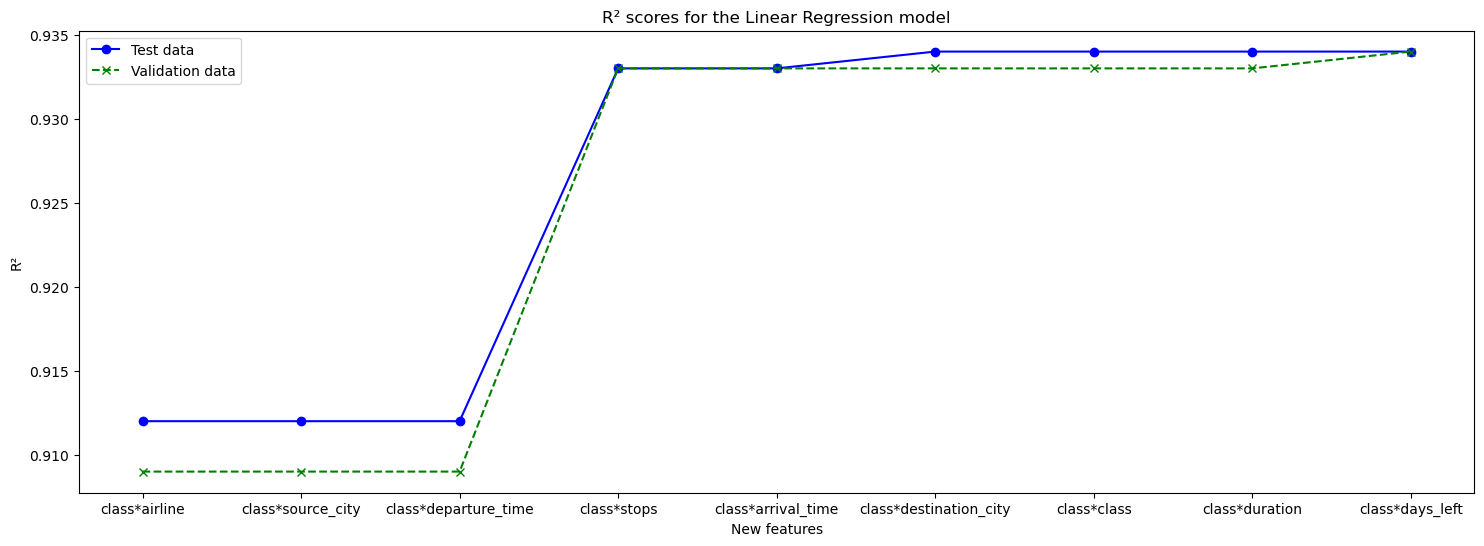

In [10]:
# R^2
plt.figure(figsize=(18,6))
plt.plot(new_features, lr_r2_scores, label='Test data', color='blue', marker='o', linestyle='-')
plt.plot(new_features, lr_r2_val_scores, label='Validation data', color='green', marker='x', linestyle='--')
plt.ylabel('R\u00b2')
plt.xlabel('New features')
plt.title('R\u00b2 scores for the Linear Regression model')
plt.legend()
plt.savefig('lr_model_r2.jpg')
plt.show()

In [11]:
lr_r2_df = pd.concat([lr_cols_scores[['Features', 'R\u00b2']], lr_cols_val_scores['R\u00b2 val']], axis=1)
lr_r2_df.sort_values(by='R\u00b2', ascending=False).head()

,Features,R²,R² val
5,class*destination_city,0.934,0.933
6,class*class,0.934,0.933
7,class*duration,0.934,0.933
8,class*days_left,0.934,0.934
3,class*stops,0.933,0.933


The feature with the highest R$^2$ for both testing and validation data is **days_left**

### MSE and RMSE plots and table

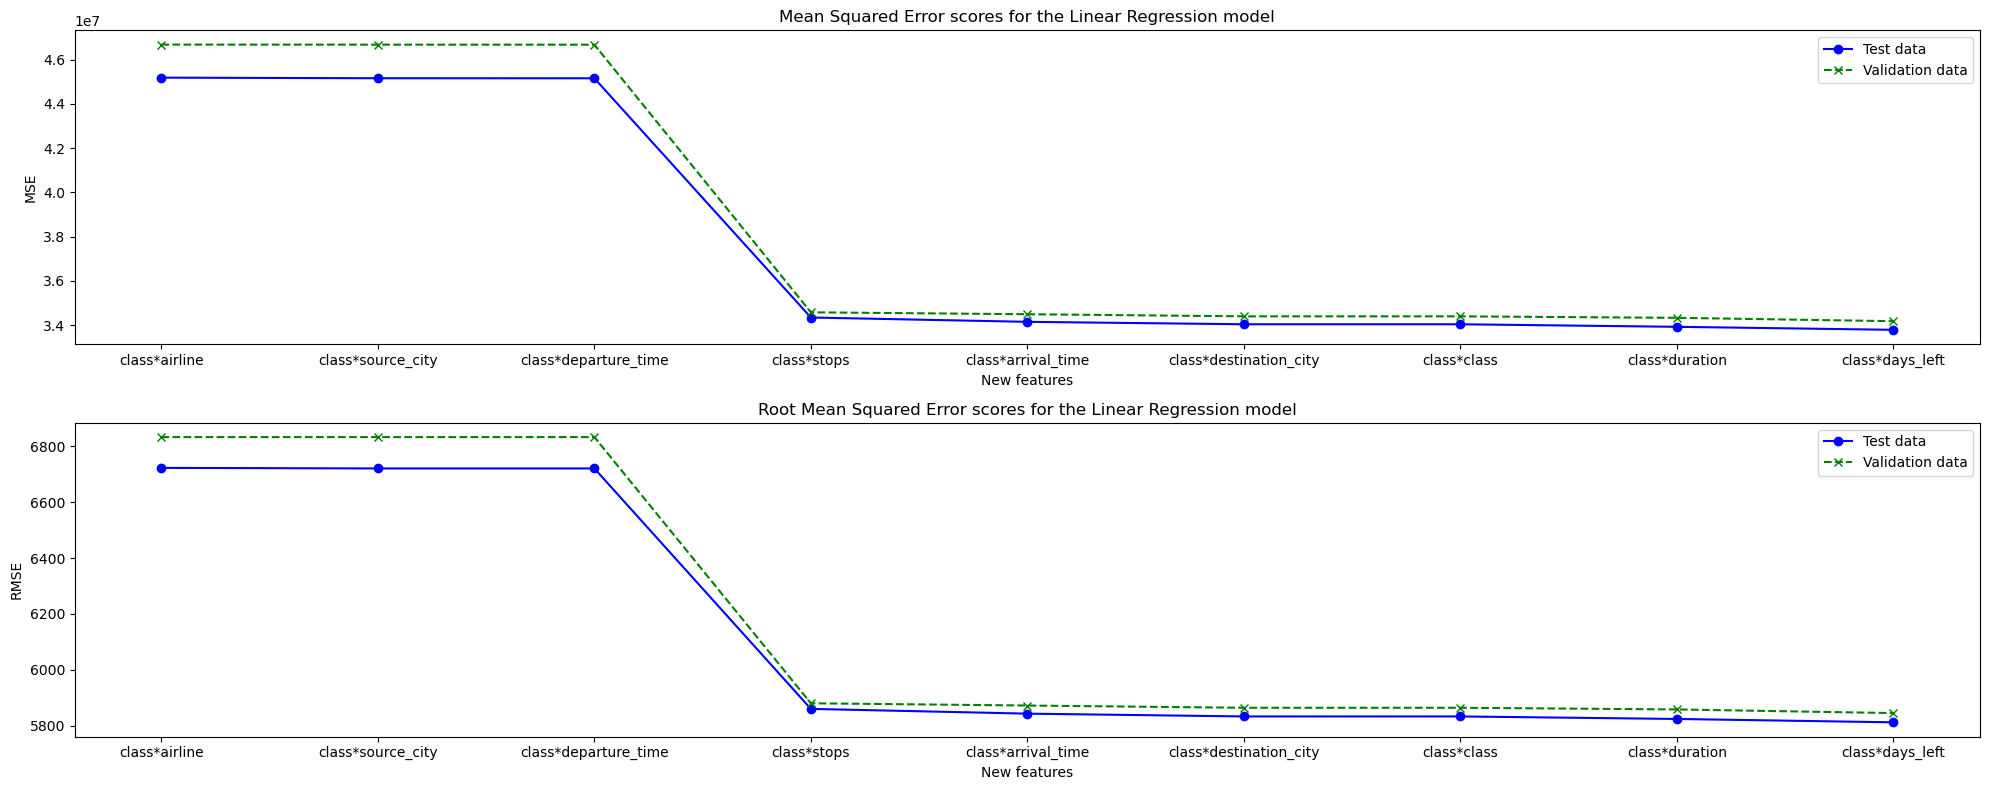

In [12]:
fig, ax = plt.subplots(2,1, figsize=(20,8))


# MSE
ax[0].plot(new_features, lr_mse_scores, label='Test data', color='blue', marker='o', linestyle='-')
ax[0].plot(new_features, lr_mse_val_scores, label='Validation data', color='green', marker='x', linestyle='--')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('New features')
ax[0].set_title('Mean Squared Error scores for the Linear Regression model')
ax[0].legend()


# RMSE
ax[1].plot(new_features, lr_rmse_scores, label='Test data', color='blue', marker='o', linestyle='-')
ax[1].plot(new_features, lr_rmse_val_scores, label='Validation data', color='green', marker='x', linestyle='--')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('New features')
ax[1].set_title('Root Mean Squared Error scores for the Linear Regression model')
ax[1].legend()

plt.savefig('lr_model_mse_rmse_plot.jpg')

plt.tight_layout()
plt.show()

In [13]:
lr_rmse_df = pd.concat([lr_cols_scores[['Features', 'RMSE']], lr_cols_val_scores['RMSE val']], axis=1)
lr_rmse_df.sort_values(by='RMSE').head()

,Features,RMSE,RMSE val
8,class*days_left,5813.0,5846
7,class*duration,5825.0,5859
5,class*destination_city,5834.0,5865
6,class*class,5834.0,5865
4,class*arrival_time,5844.0,5873


The feature with the lowest **RMSE** for both testing and validation is **days_left**

### MAE and MAPE plots and table

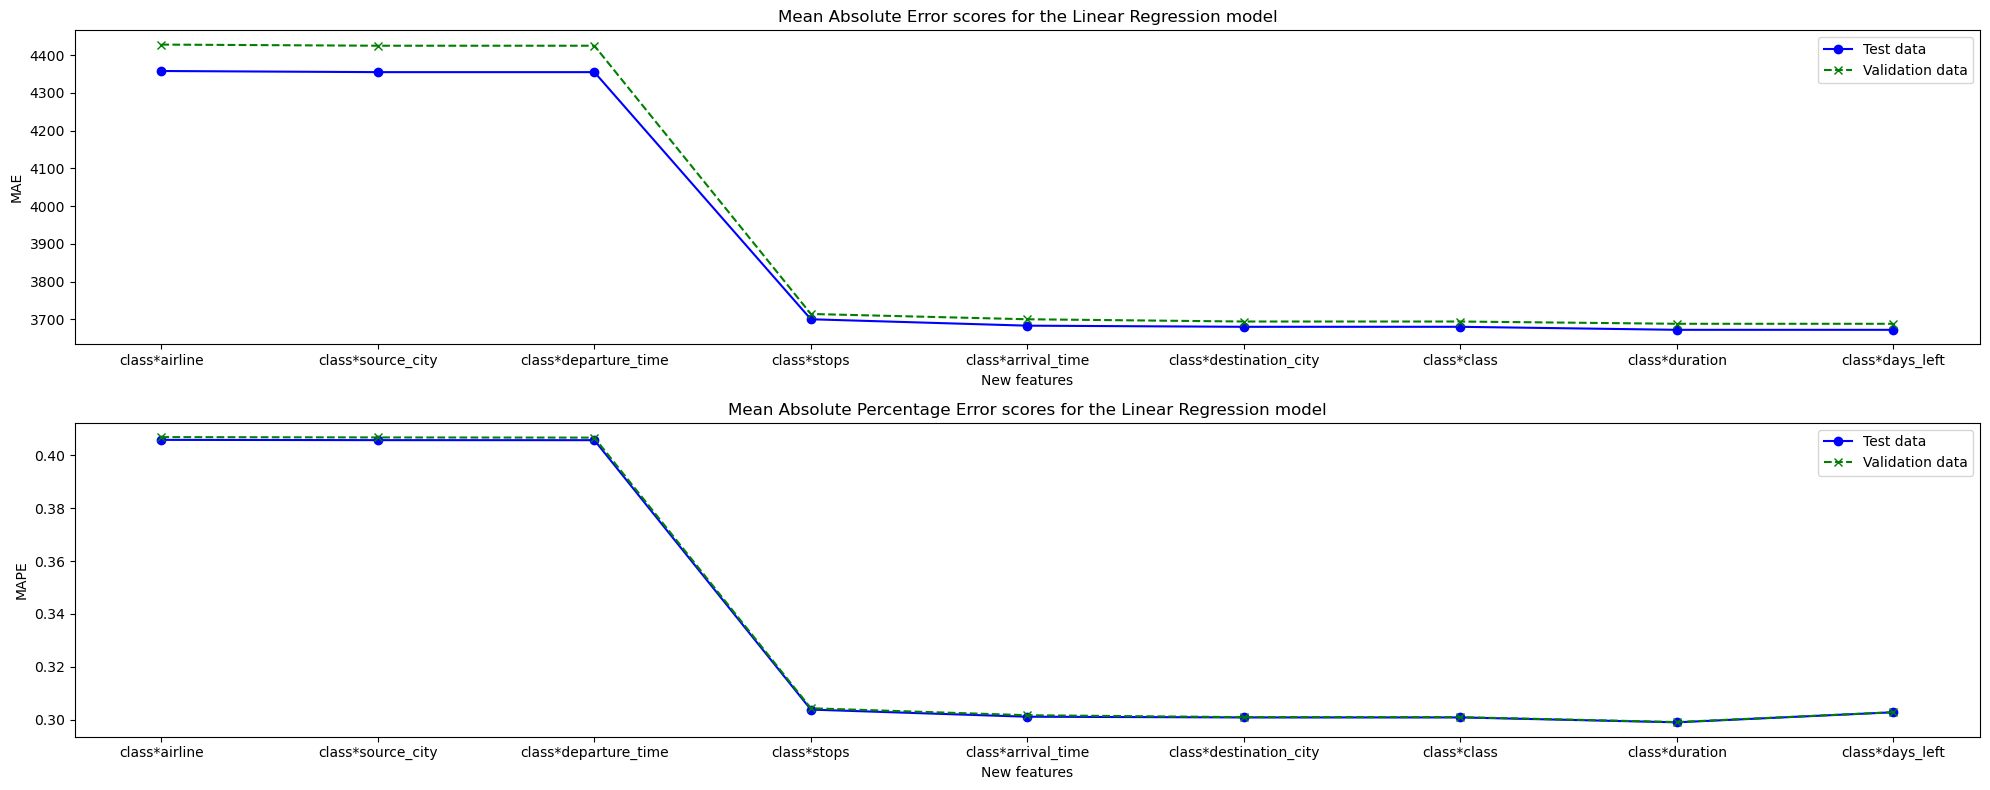

In [14]:
# Plot the MAE and MAPE scores
fig, ax = plt.subplots(2,1, figsize=(20,8))


# MAE
ax[0].plot(new_features, lr_mae_scores, label='Test data', color='blue', marker='o', linestyle='-')
ax[0].plot(new_features, lr_mae_val_scores, label='Validation data', color='green', marker='x', linestyle='--')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('New features')
ax[0].set_title('Mean Absolute Error scores for the Linear Regression model')
ax[0].legend()

# MAPE
ax[1].plot(new_features, lr_mape_scores, label='Test data', color='blue', marker='o', linestyle='-')
ax[1].plot(new_features, lr_mape_val_scores, label='Validation data', color='green', marker='x', linestyle='--')
ax[1].set_ylabel('MAPE')
ax[1].set_xlabel('New features')
ax[1].set_title('Mean Absolute Percentage Error scores for the Linear Regression model')
ax[1].legend()

plt.savefig('lr_model_mae_mpe_plot.jpg')
plt.tight_layout()
plt.show()

In [15]:
lr_ma_df = pd.concat([lr_cols_scores[['Features', 'MAE', 'MAPE']], lr_cols_val_scores[['MAE val','MAPE val']]], axis=1)
lr_ma_df.sort_values(by='MAPE').head()

,Features,MAE,MAPE,MAE val,MAPE val
7,class*duration,3672.0,0.299008,3688.0,0.299105
5,class*destination_city,3680.0,0.300859,3694.0,0.300963
6,class*class,3680.0,0.300859,3694.0,0.300963
4,class*arrival_time,3683.0,0.301125,3700.0,0.301685
8,class*days_left,3672.0,0.302810,3688.0,0.302829


In [16]:
lr_metrics_df = lr_r2_df.merge(lr_rmse_df, on='Features').merge(lr_ma_df, on='Features')
lr_metrics_df

,Features,R²,R² val,RMSE,RMSE val,MAE,MAPE,MAE val,MAPE val
0,class*airline,0.912,0.909,6722.0,6832,4358.0,0.405869,4428.0,0.406919
1,class*source_city,0.912,0.909,6720.0,6832,4355.0,0.405767,4425.0,0.406792
2,class*departure_time,0.912,0.909,6720.0,6832,4355.0,0.405754,4425.0,0.406717
3,class*stops,0.933,0.933,5861.0,5881,3700.0,0.303820,3714.0,0.304333
4,class*arrival_time,0.933,0.933,5844.0,5873,3683.0,0.301125,3700.0,0.301685
5,class*destination_city,0.934,0.933,5834.0,5865,3680.0,0.300859,3694.0,0.300963
6,class*class,0.934,0.933,5834.0,5865,3680.0,0.300859,3694.0,0.300963
7,class*duration,0.934,0.933,5825.0,5859,3672.0,0.299008,3688.0,0.299105
8,class*days_left,0.934,0.934,5813.0,5846,3672.0,0.302810,3688.0,0.302829


In [17]:
os.getcwd()

'C:\\Users\\adre9\\Springboard 2024\\Springboard_2024_GH\\Capstone Project 2\\Notebooks\\Modeling'

In [18]:
lr_metrics_df.to_csv('lr_metrics_df.csv',index=False)

Feature with the lowest of MAE and MAPE for both testing and validation data is **duration**. Although **days_left** has the same MAE with slightly higher MAPE.

From the calculated metrics it looks like **class*duration** and **class*days_left** before buying the ticket should be considered as the model choices. Although it would also be worth considering **class*stops** since the number of stops does also have an impact on flight duration.

In [19]:
lr_dur_dl = lr_metrics_df.loc[(lr_metrics_df['Features'] == 'class*duration')|(lr_metrics_df['Features'] == 'class*days_left')]
lr_dur_dl

,Features,R²,R² val,RMSE,RMSE val,MAE,MAPE,MAE val,MAPE val
7,class*duration,0.934,0.933,5825.0,5859,3672.0,0.299008,3688.0,0.299105
8,class*days_left,0.934,0.934,5813.0,5846,3672.0,0.302810,3688.0,0.302829


In [20]:
lr_dur_dl = lr_dur_dl.rename(columns={'Features':'Model'})
lr_dur_dl

,Model,R²,R² val,RMSE,RMSE val,MAE,MAPE,MAE val,MAPE val
7,class*duration,0.934,0.933,5825.0,5859,3672.0,0.299008,3688.0,0.299105
8,class*days_left,0.934,0.934,5813.0,5846,3672.0,0.302810,3688.0,0.302829


In [21]:
lr_dur_dl['Model'] = lr_dur_dl['Model'].replace({'class*duration':'LR class*duration',
                           'class*days_left':'LR class*days_left'})
lr_dur_dl

,Model,R²,R² val,RMSE,RMSE val,MAE,MAPE,MAE val,MAPE val
7,LR class*duration,0.934,0.933,5825.0,5859,3672.0,0.299008,3688.0,0.299105
8,LR class*days_left,0.934,0.934,5813.0,5846,3672.0,0.302810,3688.0,0.302829


In [22]:
lr_final_metrics_df = lr_dur_dl

## Lasso

In [24]:
# Importing RF Reg model
from sklearn.linear_model import Lasso, LassoCV

In [25]:
# Fitting a LassoCV for finding the optimal alpha parameter
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
best_alpha = lasso_cv.alpha_

# Fitting the Lasso model with best alpha
lasso_model = Lasso(alpha=best_alpha).fit(X_train, y_train)

print(f'Best alpha: {best_alpha}')

Best alpha: 9.897882894872954


In [139]:
# Predicitng
y_pred_ls = lasso_model.predict(X_test)
y_pred_ls_val = lasso_model.predict(X_val)

# Metrics for the Lasso model
r2_lasso = round(r2_score(y_test, y_pred_ls),4)
r2_lasso_val = round(r2_score(y_val, y_pred_ls_val),4)

rmse_lasso = round(root_mean_squared_error(y_test, y_pred_ls),0)
rmse_lasso_val = round(root_mean_squared_error(y_val, y_pred_ls_val),0)

mae_lasso = round(mean_absolute_error(y_test, y_pred_ls),0)
mae_lasso_val = round(mean_absolute_error(y_val, y_pred_ls_val),0)

mape_lasso = round(mean_absolute_percentage_error(y_test, y_pred_ls),5)
mape_lasso_val = round(mean_absolute_percentage_error(y_val, y_pred_ls_val),5)

# Creating a dataframe of the Lasso model metrics
lasso_final_metrics_df = pd.DataFrame({
    'Model': 'Lasso',
    'R\u00b2':r2_lasso,
    'R\u00b2 val':r2_lasso_val,
    'RMSE': rmse_lasso,
    'RMSE val':rmse_lasso_val,
    'MAE':mae_lasso,
    'MAE val':mae_lasso_val,
    'MAPE':mape_lasso,
    'MAPE val':mape_lasso_val
}, index=[0])

In [140]:
lasso_final_metrics_df

,Model,R²,R² val,RMSE,RMSE val,MAE,MAE val,MAPE,MAPE val
0,Lasso,0.9339,0.9334,5824.0,5853.0,3679.0,3694.0,0.30502,0.30505


## Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [61]:
# Iterating through different learning rates to find the best metrics
def eval_gbr_model(y_true, y_pred):
    return {
            'R\u00b2': round(r2_score(y_true, y_pred),4),
            'MSE': round(mean_squared_error(y_true, y_pred),0),
            'RMSE': round(root_mean_squared_error(y_true, y_pred),0),
            'MAE': round(mean_absolute_error(y_true, y_pred),0),
            'MAPE': round(mean_absolute_percentage_error(y_true, y_pred),4)
    }

learning_rates = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]

test_results = []
val_results = []

for i in learning_rates:
    gbr_model = GradientBoostingRegressor(n_estimators=50, learning_rate=i,
                                    max_depth=3, subsample=0.8, random_state=42)
    gbr_model.fit(X_train, y_train)
    
    y_gbr_pred = gbr_model.predict(X_test)
    y_gbr_pred_val = gbr_model.predict(X_val)

    test_metrics = eval_gbr_model(y_test, y_gbr_pred)
    val_metrics = eval_gbr_model(y_val, y_gbr_pred_val)

    test_results.append(test_metrics)
    val_results.append(val_metrics)
    

test_results_df = pd.DataFrame(test_results)
test_results_df.insert(0, 'Test Data Learning Rates', learning_rates)

val_results_df = pd.DataFrame(val_results)
val_results_df.insert(0, 'Validation Data Learning Rates', learning_rates)

In [62]:
test_results_df

,Test Data Learning Rates,R²,MSE,RMSE,MAE,MAPE
0,0.01,0.5941,208304428.0,14433.0,12078.0,1.5093
1,0.03,0.8948,53967964.0,7346.0,5418.0,0.6685
2,0.05,0.9387,31462305.0,5609.0,3690.0,0.3825
3,0.07,0.9475,26936017.0,5190.0,3245.0,0.2883
4,0.10,0.9520,24654381.0,4965.0,3043.0,0.2455
5,0.15,0.9545,23346880.0,4832.0,2919.0,0.2212
6,0.20,0.9555,22828292.0,4778.0,2878.0,0.2125
7,0.30,0.9578,21660724.0,4654.0,2806.0,0.2051


In [65]:
val_results_df

,Validation Data Learning Rates,R²,MSE,RMSE,MAE,MAPE
0,0.01,0.5936,208898726.0,14453.0,12078.0,1.5003
1,0.03,0.8945,54256162.0,7366.0,5427.0,0.6633
2,0.05,0.9383,31725815.0,5633.0,3699.0,0.3792
3,0.07,0.9471,27201473.0,5216.0,3262.0,0.2864
4,0.10,0.9514,24962196.0,4996.0,3065.0,0.2443
5,0.15,0.9538,23739828.0,4872.0,2945.0,0.2206
6,0.20,0.9547,23268861.0,4824.0,2905.0,0.2115
7,0.30,0.9570,22098757.0,4701.0,2830.0,0.2038


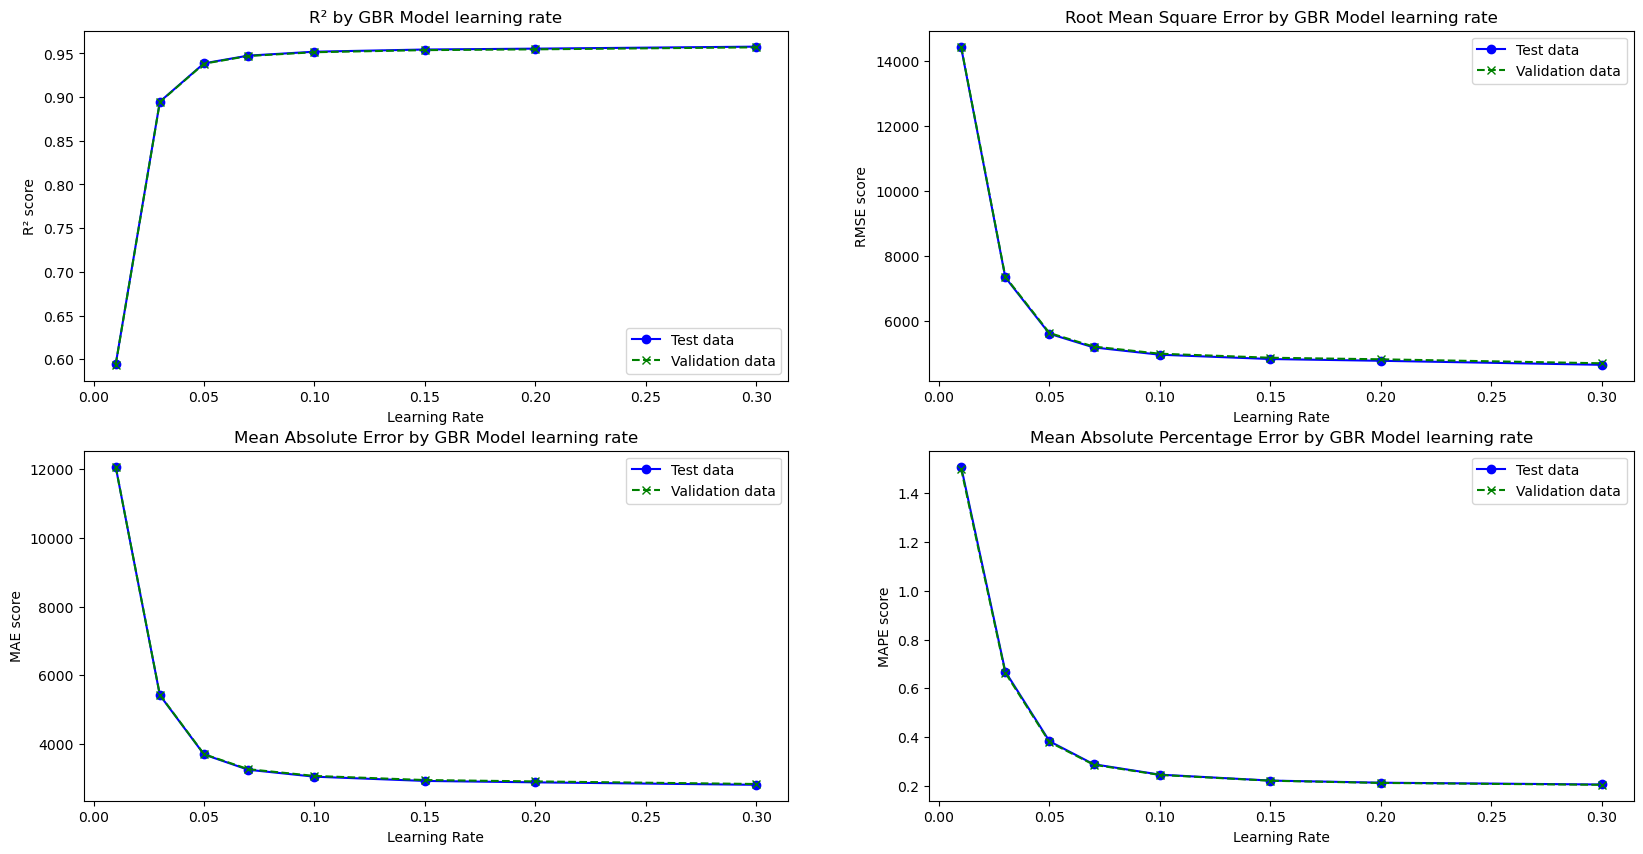

In [70]:
# Plotting out the metrics
# Except MSE since RMSE has the same units
fig, ax = plt.subplots(2,2, figsize=(20,10))

# R^2
ax[0,0].plot(learning_rates, test_results_df['R\u00b2'], label='Test data', color='blue', marker='o', linestyle='-')
ax[0,0].plot(learning_rates, val_results_df['R\u00b2'], label='Validation data', color='green', marker='x', linestyle='--')
ax[0,0].set_xlabel('Learning Rate')
ax[0,0].set_ylabel('R\u00b2 score')
ax[0,0].legend()
ax[0,0].set_title('R\u00b2 by GBR Model learning rate')

# RMSE
ax[0,1].plot(learning_rates, test_results_df['RMSE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[0,1].plot(learning_rates, val_results_df['RMSE'], label='Validation data', color='green', marker='x', linestyle='--')
ax[0,1].set_xlabel('Learning Rate')
ax[0,1].set_ylabel('RMSE score')
ax[0,1].legend()
ax[0,1].set_title('Root Mean Square Error by GBR Model learning rate')

# MAE
ax[1,0].plot(learning_rates, test_results_df['MAE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[1,0].plot(learning_rates, val_results_df['MAE'], label='Validation data', color='green', marker='x', linestyle='--')
ax[1,0].set_xlabel('Learning Rate')
ax[1,0].set_ylabel('MAE score')
ax[1,0].legend()
ax[1,0].set_title('Mean Absolute Error by GBR Model learning rate')

# MAPE
ax[1,1].plot(learning_rates, test_results_df['MAPE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[1,1].plot(learning_rates, val_results_df['MAPE'], label='Validation data', color='green', marker='x', linestyle='--')
ax[1,1].set_xlabel('Learning Rate')
ax[1,1].set_ylabel('MAPE score')
ax[1,1].legend()
ax[1,1].set_title('Mean Absolute Percentage Error by GBR Model learning rate')

plt.savefig('GBR_learning_rate_metrics_plot.jpg')
plt.show()

Learning rate of **0.07** would be a safe choice (maybe even **0.1**) as it outputs great model performance with high R$^2$ and lower RMSE, MAE, and MAPE.

However, anything more than that runs the risk of overfitting.

In [67]:
# Now let's tune the n_estimators with a new given learning rate of 0.1

n_estimators = [50, 100, 150, 200]
test_results2 = []
val_results2 = []
for n in n_estimators:
    gbr2 = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1,
                                     max_depth=3, subsample=0.8, random_state=42)
    gbr2.fit(X_train, y_train)
    
    y_gbr_pred = gbr2.predict(X_test)
    y_gbr_pred_val = gbr2.predict(X_val)

    test_metrics = eval_gbr_model(y_test, y_gbr_pred)
    val_metrics = eval_gbr_model(y_val, y_gbr_pred_val)

    test_results2.append(test_metrics)
    val_results2.append(val_metrics)

test_results2_df = pd.DataFrame(test_results2)
test_results2_df.insert(0, 'n_estimators', n_estimators)

val_results2_df = pd.DataFrame(val_results2)
val_results2_df.insert(0, 'n_estimators', n_estimators)

In [68]:
test_results2_df

,n_estimators,R²,MSE,RMSE,MAE,MAPE
0,50,0.9520,24654381.0,4965.0,3043.0,0.2455
1,100,0.9559,22650853.0,4759.0,2860.0,0.2108
2,150,0.9578,21658028.0,4654.0,2797.0,0.2037
3,200,0.9590,21022471.0,4585.0,2758.0,0.2000


In [69]:
val_results2_df

,n_estimators,R²,MSE,RMSE,MAE,MAPE
0,50,0.9514,24962196.0,4996.0,3065.0,0.2443
1,100,0.9551,23089674.0,4805.0,2888.0,0.2100
2,150,0.9571,22059935.0,4697.0,2819.0,0.2027
3,200,0.9584,21387289.0,4625.0,2777.0,0.1988


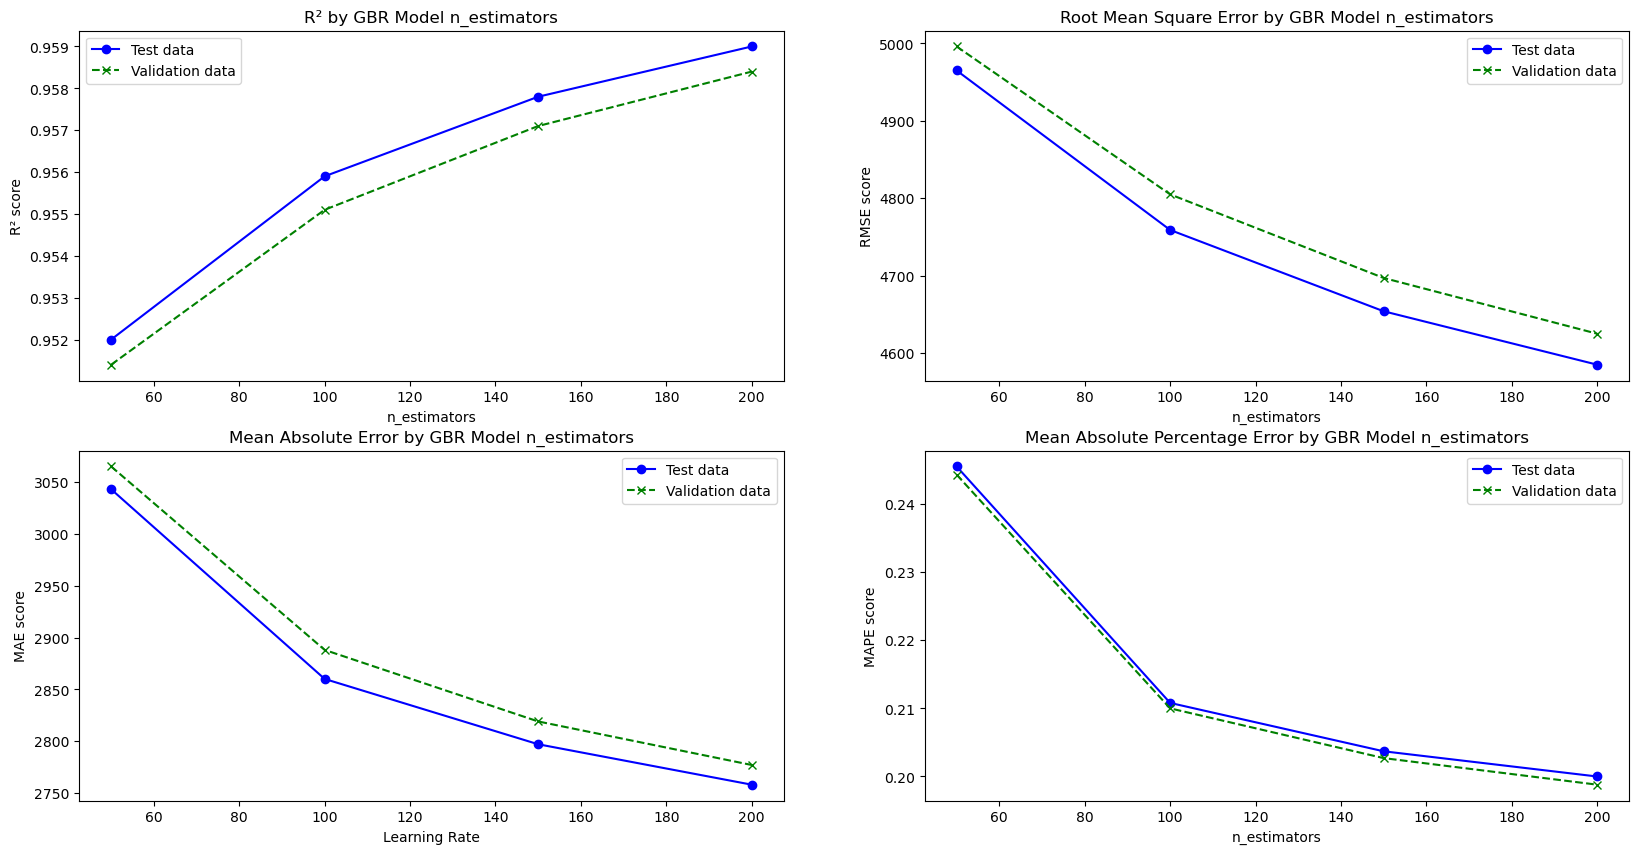

In [72]:
# Plotting out the metrics
# Except MSE since RMSE has the same units
fig, ax = plt.subplots(2,2, figsize=(20,10))

# R^2
ax[0,0].plot(n_estimators, test_results2_df['R\u00b2'], label='Test data', color='blue', marker='o', linestyle='-')
ax[0,0].plot(n_estimators, val_results2_df['R\u00b2'], label='Validation data', color='green', marker='x', linestyle='--')
ax[0,0].set_xlabel('n_estimators')
ax[0,0].set_ylabel('R\u00b2 score')
ax[0,0].legend()
ax[0,0].set_title('R\u00b2 by GBR Model n_estimators')

# RMSE
ax[0,1].plot(n_estimators, test_results2_df['RMSE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[0,1].plot(n_estimators, val_results2_df['RMSE'], label='Validation data', color='green', marker='x', linestyle='--')
ax[0,1].set_xlabel('n_estimators')
ax[0,1].set_ylabel('RMSE score')
ax[0,1].legend()
ax[0,1].set_title('Root Mean Square Error by GBR Model n_estimators')

# MAE
ax[1,0].plot(n_estimators, test_results2_df['MAE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[1,0].plot(n_estimators, val_results2_df['MAE'], label='Validation data', color='green', marker='x', linestyle='--')
ax[1,0].set_xlabel('Learning Rate')
ax[1,0].set_ylabel('MAE score')
ax[1,0].legend()
ax[1,0].set_title('Mean Absolute Error by GBR Model n_estimators')

# MAPE
ax[1,1].plot(n_estimators, test_results2_df['MAPE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[1,1].plot(n_estimators, val_results2_df['MAPE'], label='Validation data', color='green', marker='x', linestyle='--')
ax[1,1].set_xlabel('n_estimators')
ax[1,1].set_ylabel('MAPE score')
ax[1,1].legend()
ax[1,1].set_title('Mean Absolute Percentage Error by GBR Model n_estimators')

plt.savefig('GBR_nestimators_metrics_plot.jpg')
plt.show()

n_estimators at 100 should be sufficient and safe as to not push the boundaries further of overfitting and the MAPE already drops quite a bit from about 0.24 to 0.21 when increasing 50 to 100 estimators.

In [131]:
final_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42)

final_gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42, subsample=0.8)

In [132]:
# Predicting values from the GBR model
y_gbrf_pred = final_gbr.predict(X_test)
y_gbrf_val_pred = final_gbr.predict(X_val)

# Metrics for the GBR model
gbrf_r2 = round(r2_score(y_test, y_gbrf_pred),3)
gbrf_r2_val = round(r2_score(y_val, y_gbrf_val_pred),3)

gbrf_rmse = round(root_mean_squared_error(y_test, y_gbrf_pred),0)
gbrf_rmse_val = round(root_mean_squared_error(y_val, y_gbrf_val_pred),0)

gbrf_mae = round(mean_absolute_error(y_test, y_gbrf_pred),0)
gbrf_mae_val = round(mean_absolute_error(y_val, y_gbrf_val_pred),0)

gbrf_mape = round(mean_absolute_percentage_error(y_test, y_gbrf_pred),4)
gbrf_mape_val = round(mean_absolute_percentage_error(y_val, y_gbrf_val_pred),4)

final_gbr_df = pd.DataFrame({
    'Model': 'Gradient Boosting',
    'R\u00b2': gbrf_r2,
    'R\u00b2 val': gbrf_r2_val,
    'RMSE':gbrf_rmse,
    'RMSE val':gbrf_rmse_val,
    'MAE':gbrf_mae,
    'MAE val':gbrf_mae_val,
    'MAPE':gbrf_mape,
    'MAPE val':gbrf_mape_val}, index=[0])
final_gbr_df

,Model,R²,R² val,RMSE,RMSE val,MAE,MAE val,MAPE,MAPE val
0,Gradient Boosting,0.956,0.955,4759.0,4805.0,2860.0,2888.0,0.2108,0.21


## Final results

In [158]:
models_metrics_df = pd.concat([lr_final_metrics_df, lasso_final_metrics_df, final_gbr_df])
models_metrics_df

,Model,R²,R² val,RMSE,RMSE val,MAE,MAPE,MAE val,MAPE val
7,LR class*duration,0.9340,0.9330,5825.0,5859.0,3672.0,0.299008,3688.0,0.299105
8,LR class*days_left,0.9340,0.9340,5813.0,5846.0,3672.0,0.302810,3688.0,0.302829
0,Lasso,0.9339,0.9334,5824.0,5853.0,3679.0,0.305020,3694.0,0.305050
0,Gradient Boosting,0.9560,0.9550,4759.0,4805.0,2860.0,0.210800,2888.0,0.210000


In [162]:
# Saving the dataframe of the models metrics
models_metrics_df.to_csv('reg_models_metrics_df.csv', index=False)

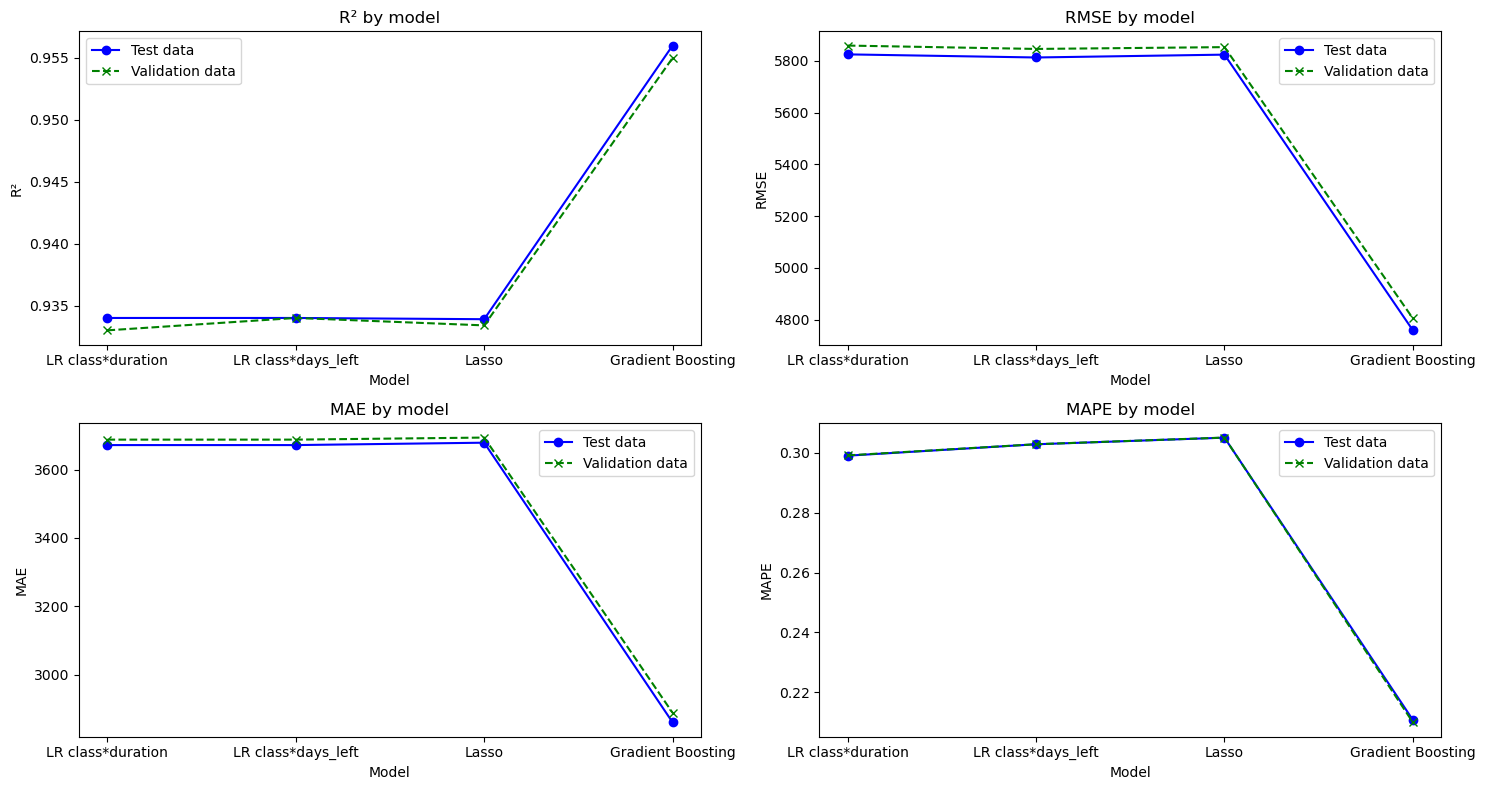

In [161]:
# Plotting the final metrics
fig, ax = plt.subplots(2,2, figsize=(15,8))

# R^2
ax[0,0].plot(models_metrics_df['Model'], models_metrics_df['R\u00b2'], label='Test data', color='blue', marker='o', linestyle='-')
ax[0,0].plot(models_metrics_df['Model'], models_metrics_df['R\u00b2 val'], label='Validation data', color='green', marker='x', linestyle='--')
ax[0,0].set_xlabel('Model')
ax[0,0].set_ylabel('R\u00b2')
ax[0,0].set_title('R\u00b2 by model')
ax[0,0].legend()

# RMSE
ax[0,1].plot(models_metrics_df['Model'], models_metrics_df['RMSE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[0,1].plot(models_metrics_df['Model'], models_metrics_df['RMSE val'], label='Validation data', color='green', marker='x', linestyle='--')
ax[0,1].set_xlabel('Model')
ax[0,1].set_ylabel('RMSE')
ax[0,1].set_title('RMSE by model')
ax[0,1].legend()

# MAE
ax[1,0].plot(models_metrics_df['Model'], models_metrics_df['MAE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[1,0].plot(models_metrics_df['Model'], models_metrics_df['MAE val'], label='Validation data', color='green', marker='x', linestyle='--')
ax[1,0].set_xlabel('Model')
ax[1,0].set_ylabel('MAE')
ax[1,0].set_title('MAE by model')
ax[1,0].legend()

# MAPE
ax[1,1].plot(models_metrics_df['Model'], models_metrics_df['MAPE'], label='Test data', color='blue', marker='o', linestyle='-')
ax[1,1].plot(models_metrics_df['Model'], models_metrics_df['MAPE val'], label='Validation data', color='green', marker='x', linestyle='--')
ax[1,1].set_xlabel('Model')
ax[1,1].set_ylabel('MAPE')
ax[1,1].set_title('MAPE by model')
ax[1,1].legend()

plt.savefig('reg_models_metrics.jpg')
plt.tight_layout()
plt.show()

There looks to be a clear seperation of the final metrics between the Gradient Boosting model and the other 2 models (3 if you include the 2 strongest feature candidates for the linear regression model). Besides having the highest R$^2$, it has the lowest RMSE, MAE, and MAPE.

The **Gradient Boosting Regression** model will be our model of choice.

In [163]:
#Saving the model

from joblib import dump, load

dump(final_gbr, 'ticket_price_gbr_model.joblib')

['ticket_price_gbr_model.joblib']